In [1]:
import json
from pathlib import Path

import awkward as ak
import numpy as np
import hist
import mplhep as hep
import matplotlib.pyplot as plt

from data_processing import process_data

In [2]:
SIGNAL_FILEPATHS = [
    '/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/output_ttHKiller_eval_postEE/GluGluToHH_nominal_ttH_killer_preds.parquet',
    '/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/output_ttHKiller_eval_preEE/GluGluToHH_nominal_ttH_killer_preds.parquet'
]
BKG_FILEPATHS = [
    '/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/output_ttHKiller_eval_postEE/ttHToGG_nominal_ttH_killer_preds.parquet',
    '/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/output_ttHKiller_eval_preEE/ttHToGG_nominal_ttH_killer_preds.parquet'
]

sig_samples_list = [ak.from_parquet(sig_filepath) for sig_filepath in SIGNAL_FILEPATHS]
sig_sample = ak.concatenate(sig_samples_list)
bkg_samples_list = [ak.from_parquet(bkg_filepath) for bkg_filepath in BKG_FILEPATHS]
bkg_sample = ak.concatenate(bkg_samples_list)

CURRENT_DIRPATH = str(Path().absolute())
VERSION = 'v10'
VARS = 'extra_vars+max'
CURRENT_TIME = '2024-10-29_00-47-20'
OUTPUT_DIRPATH = CURRENT_DIRPATH + f"/model_outputs/{VERSION}/{VARS}/" + CURRENT_TIME
SEED = 21
MOD_VALS = (5, 5)

(
    data_df_dict, data_test_df_dict, 
    data_list_dict, data_hlf_dict, label_dict, 
    data_list_test_dict, data_hlf_test_dict, label_test_dict, 
    high_level_fields_dict, input_hlf_vars_dict, hlf_vars_columns_dict,
    data_aux_dict, data_test_aux_dict
) = process_data(
    6, 7, SIGNAL_FILEPATHS, BKG_FILEPATHS, OUTPUT_DIRPATH, seed=SEED, mod_vals=MOD_VALS, k_fold_test=True
)

Data list: (413735, 6, 7)
Data HLF: (413735, 15)
n signal = 136530, n bkg = 277205
Data list test: (103521, 6, 7)
Data HLF test: (103521, 15)
n signal = 34224, n bkg = 69297
Data list: (413918, 6, 7)
Data HLF: (413918, 15)
n signal = 136466, n bkg = 277452
Data list test: (103338, 6, 7)
Data HLF test: (103338, 15)
n signal = 34288, n bkg = 69050
Data list: (413265, 6, 7)
Data HLF: (413265, 15)
n signal = 136638, n bkg = 276627
Data list test: (103991, 6, 7)
Data HLF test: (103991, 15)
n signal = 34116, n bkg = 69875
Data list: (413725, 6, 7)
Data HLF: (413725, 15)
n signal = 136671, n bkg = 277054
Data list test: (103531, 6, 7)
Data HLF test: (103531, 15)
n signal = 34083, n bkg = 69448
Data list: (414381, 6, 7)
Data HLF: (414381, 15)
n signal = 136711, n bkg = 277670
Data list test: (102875, 6, 7)
Data HLF test: (102875, 15)
n signal = 34043, n bkg = 68832


In [6]:

def plot_score_from_IN_perf(weights, n_bins=50):
    with open(
        '/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v10/extra_vars+max/2024-10-29_00-47-20/2024-10-29_00-47-20_IN_perf.json', 'r'
    ) as f:
        IN_info = json.load(f)

    flat_preds = np.concatenate([
        np.exp(IN_info['all_preds'][i])[:, 1] for i in range(len(IN_info['all_preds']))
    ], axis=None)
    flat_labels = np.concatenate([
        np.array(IN_info['all_labels'][i]) for i in range(len(IN_info['all_preds']))
    ], axis=None)
    sig_preds = flat_preds[flat_labels == 1]
    bkg_preds = flat_preds[flat_labels == 0]

    hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
    sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_preds, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig_preds))
    bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_preds, weight=weights['bkg'] if weights['bkg'] is not None else np.ones_like(bkg_preds))
    hep.histplot(
        [sig_hist, bkg_hist],
        yerr=(True if weights['sig'] is not None else False),
        alpha=0.5, density=(False if weights['sig'] is not None else True), histtype='step',
        label=["ggF HH", "ttH"], linestyle=['solid', 'solid'], color=['blue', 'red']
    )

def plot_score_from_eval(samples, weights, n_bins=50):
    sig_preds = ak.to_numpy(samples['sig']['ttH_killer_preds'])
    bkg_preds = ak.to_numpy(samples['bkg']['ttH_killer_preds'])

    hist_axis = hist.axis.Regular(n_bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
    sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig_preds, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig_preds))
    bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg_preds, weight=weights['bkg'] if weights['bkg'] is not None else np.ones_like(bkg_preds))
    hep.histplot(
        [sig_hist, bkg_hist],
        yerr=(True if weights['sig'] is not None else False),
        alpha=0.5, density=(False if weights['sig'] is not None else True), histtype='step',
        label=["ggF HH", "ttH"], linestyle=['dashed', 'dashed'], color=['yellow', 'green']
    )

In [4]:
IN_weights = {'sig': [], 'bkg': []}
for fold_idx in range(len(data_test_aux_dict)):
    IN_weights['sig'].append(
        (
            data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()
        )[label_test_dict[f'fold_{fold_idx}'] == 1]
    )
    IN_weights['bkg'].append(
        (
            data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()
        )[label_test_dict[f'fold_{fold_idx}'] == 0]
    )
IN_weights['sig'] = np.concatenate(IN_weights['sig'])
IN_weights['bkg'] = np.concatenate(IN_weights['bkg'])

weights = {'sig': ak.to_numpy(sig_sample['eventWeight']), 'bkg': ak.to_numpy(bkg_sample['eventWeight'])}
samples = {'sig': sig_sample, 'bkg': bkg_sample}


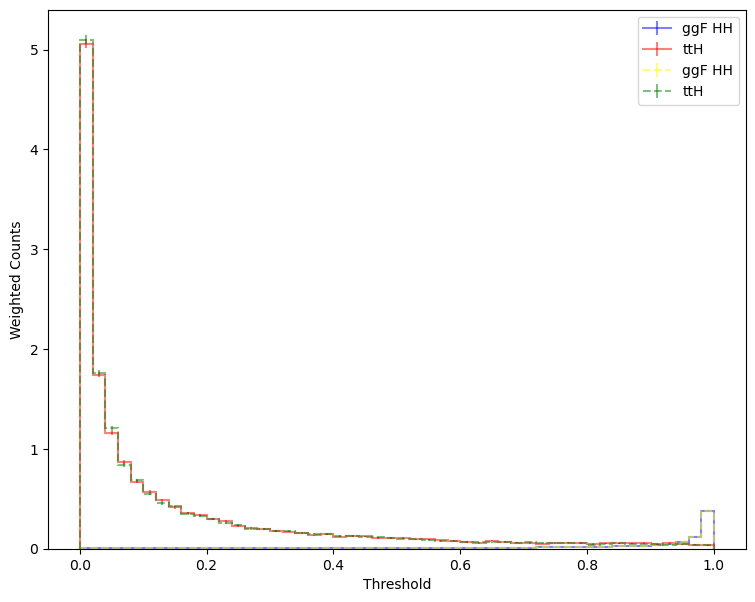

In [7]:
plt.figure(figsize=(9,7))

plot_score_from_IN_perf(IN_weights)
plot_score_from_eval(samples, weights)

plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Threshold')
plt.ylabel('Weighted Counts')
plt.show()

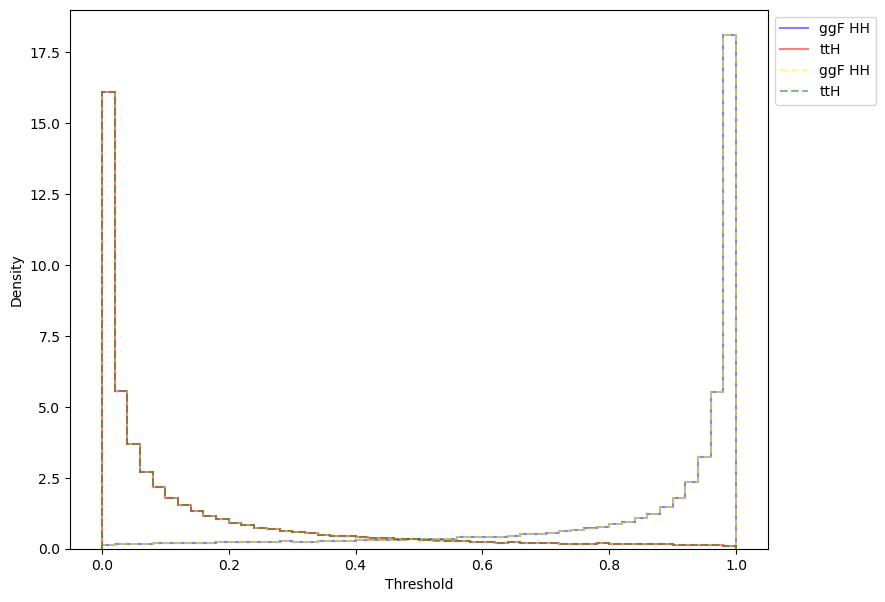

In [8]:
density_weights = {'sig': None, 'bkg': None}

plt.figure(figsize=(9,7))

plot_score_from_IN_perf(density_weights)
plot_score_from_eval(samples, density_weights)

plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Threshold')
plt.ylabel('Density')
plt.show()